# Lemon Project - Basic Model  

Raw images are 1056 x 1056 pixels
Need to make them a bit smaller to avoid having 1,115,136 input neurons! haha
The output of the model will have just 2 categories - healthy and unhealthy

#### Model Version_03 
1) Add tensorflow image resize_with_pad (rwp) so that the model will be able to accept any size image (perhaps from different webcams with different sizes/resolutions)

2) Add class weights to better balance the healthy with unhealthy as the raw data had a ratio of 1:2.64
    Healthy:   740
    Unhealthy: 1950
    
    class 0 = healthy
    class 1 = unhealthy
    
3) Improve model (how?? - better layers?)
    - Experiment with batch size
    - 

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dc880937-4378-4e63-8430-e49b31e46d3f)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image
from datetime import datetime
import os

In [ ]:
# test_img = image.imread("https://drive.google.com/file/d/1p-wcRRWwvlCrbIV_NxjmN-eQ81kwSfNs")
https://drive.google.com/file/d/1p-wcRRWwvlCrbIV_NxjmN-eQ81kwSfNs/view?usp=sharing

SyntaxError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls drive/MyDrive/Lemon_Project/raw_data/

Test_lemon  Train_lemon


In [5]:
cp -r drive/MyDrive/Lemon_Project/raw_data/ .

In [6]:
test_img = image.imread(f"raw_data/Train_lemon/Healthy_lemon/0001_E_V_120_C.jpg")

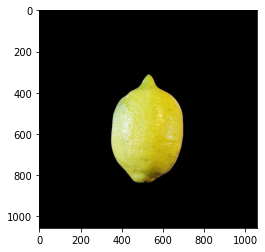

In [7]:
 plt.imshow((test_img));

In [8]:
pwd

'/content'

In [8]:
from PIL import Image
import numpy as np

img = np.array(Image.open(f"raw_data/Train_lemon/Healthy_lemon/0001_E_V_120_C.jpg"))

def strip_black_from_image(img):

    x_id = np.argwhere(np.max(img, axis = (1, 2)) > 0).reshape(-1)

    strip_img = img[x_id]
    
    y_id = np.argwhere(np.max(strip_img, axis = (0, 2)) > 0).reshape(-1)

    return strip_img[:, y_id]

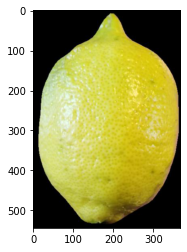

In [9]:
 plt.imshow(strip_black_from_image(test_img))

In [ ]:
# img_shape = np.shape(test_img)
# img_shape

In [ ]:
# plt.imshow(test_img)

In [ ]:
# plt.imshow(data[0])

In [10]:
# Use this method to prepare a data set for use in a model - only reads the images on when needed
# Returns a tf.data.Dataset object

from tensorflow.keras import utils

In [11]:
train_data = utils.image_dataset_from_directory('raw_data/Train_lemon', seed = 1,validation_split = 0.2, subset = 'training')
validation_data = utils.image_dataset_from_directory('raw_data/Train_lemon', seed =1, validation_split = 0.2, subset = 'validation')

Found 1883 files belonging to 2 classes.
Using 1507 files for training.
Found 1883 files belonging to 2 classes.
Using 376 files for validation.


In [38]:
train_data.class_names

['Healthy_lemon', 'Unhealthy_lemon']

## Convolutional Neural Network (CNN)

### Dimensionality

In [ ]:
from tensorflow.keras.backend import expand_dims
# from tensorflow.keras import layers
# from tensorflow.keras import models

In [ ]:
# X_train[0].shape

In [ ]:
# X_train = expand_dims(X_train)
# X_train.shape

In [ ]:
# X_test = expand_dims(X_test)
# X_test.shape

### Label Encoding

**Not sure if we need this section 

In [ ]:
# from tensorflow.keras.utils import to_categorical

# y_train_cat = to_categorical(y_train, num_classes=2)
# y_test_cat = to_categorical(y_test, num_classes=2)

### Basic CNN

In [12]:
from tensorflow.keras import layers, models, optimizers, losses, metrics

In [ ]:
# data_augmentation = models.Sequential([layers.RandomFlip("horizontal_and_vertical")])

In [22]:
def initialize_model():

    model = models.Sequential()
    
    ### Augmentation Layer before Model
    model.add(layers.RandomFlip())
    
    ### Resizing layer before Model
    model.add(layers.Resizing(512,512))

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (28,28), activation='relu', padding='same', input_shape=(512,512, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (16,16), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ## Extra Layers just for fun ##
    model.add(layers.Conv2D(64, (8,8), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (8,8), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Flattening
    model.add(layers.Flatten())
    
    ### TWO Fully Connected layer s- "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(96, activation='relu'))

    model.add(layers.Dense(12, activation='relu'))
    
    ### Last layer - Classification Layer with 1 outputs corresponding to binary option (healthy/unhealthy)
    model.add(layers.Dense(1, activation='sigmoid'))
    
    ### Model compilation
    model.compile(loss='binary_crossentropy',  #'sparse_categorical_crossentropy'
                  optimizer=optimizers.Adam(learning_rate=0.000001), 
                  metrics=['accuracy'])
    return model

### Class Imbalance

In [14]:
neg = 740 # number of healthy images
pos = 1950 #number of unhealthy images
total = neg + pos
print('Examples:\n    Total Number Of Images: {}\n    Unhealthy Lemon Images: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total Number Of Images: 2690
    Unhealthy Lemon Images: 1950 (72.49% of total)



In [15]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.82
Weight for class 1: 0.69


### Train The Model

In [ ]:
ls 

drive/  raw_data/  sample_data/


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
model = initialize_model()

es = EarlyStopping(patience=2)

histroy = model.fit(train_data, 
          batch_size=8, 
          epochs=50,
          validation_data = validation_data,
          callbacks=[es],
          class_weight = class_weight
          )

Epoch 1/50
48/48 [==============================] - 45s 899ms/step - loss: 5.4163 - accuracy: 0.3630 - val_loss: 1.5153 - val_accuracy: 0.4867
Epoch 2/50
48/48 [==============================] - 43s 887ms/step - loss: 1.3362 - accuracy: 0.4545 - val_loss: 1.1827 - val_accuracy: 0.4681
Epoch 3/50
48/48 [==============================] - 44s 890ms/step - loss: 1.0140 - accuracy: 0.5169 - val_loss: 1.0271 - val_accuracy: 0.4867
Epoch 4/50
48/48 [==============================] - 43s 881ms/step - loss: 0.8848 - accuracy: 0.5528 - val_loss: 1.0164 - val_accuracy: 0.4894
Epoch 5/50
48/48 [==============================] - 44s 899ms/step - loss: 0.8112 - accuracy: 0.5786 - val_loss: 0.8448 - val_accuracy: 0.5638
Epoch 6/50
48/48 [==============================] - 44s 890ms/step - loss: 0.7510 - accuracy: 0.6005 - val_loss: 0.8228 - val_accuracy: 0.5638
Epoch 7/50
48/48 [==============================] - 44s 890ms/step - loss: 0.7081 - accuracy: 0.6257 - val_loss: 0.8367 - val_accuracy: 0.5585

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 8)       18824     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 241, 241, 16)      32784     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 113, 113, 64)      6

### Evaluate The Model

In [ ]:
print(model.evaluate(train_data, verbose=0))

[0.49003633856773376, 0.7213006019592285]


In [24]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

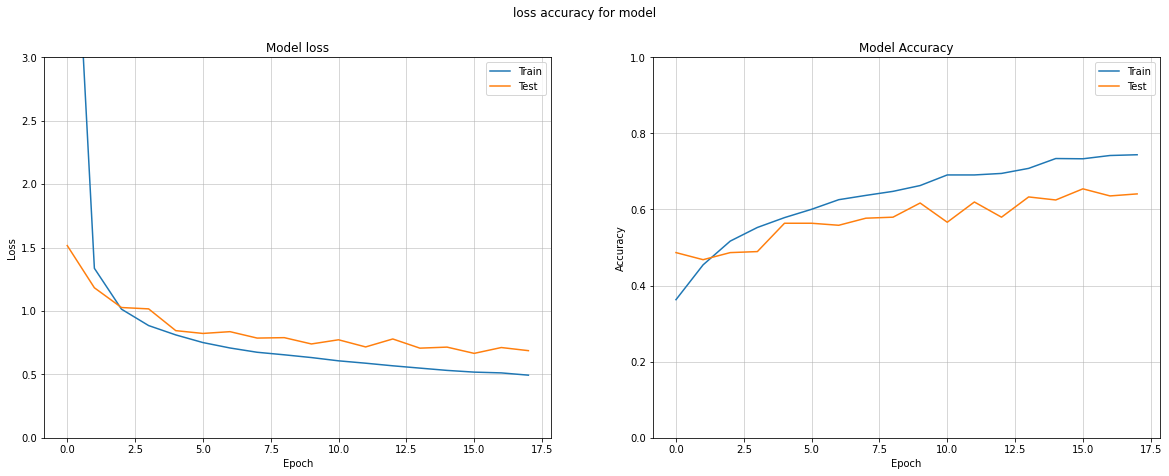

In [25]:
plot_loss_accuracy(histroy, title="loss accuracy for model")

1/1 [==============================] - 0s 449ms/step
              precision    recall  f1-score   support

           0       0.14      0.50      0.22         4
           1       0.89      0.57      0.70        28

    accuracy                           0.56        32
   macro avg       0.52      0.54      0.46        32
weighted avg       0.80      0.56      0.64        32



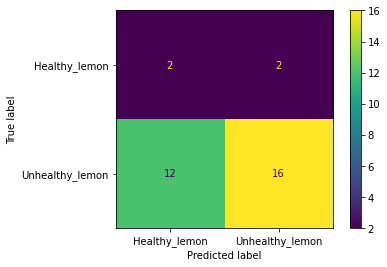

In [29]:
# confustion mTRIX

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, PrecisionRecallDisplay, precision_recall_curve

def predict_threshold(pred, threshold):
    if pred > threshold:
        return 1
    else:
        return 0

y_true_all = []
y_pred_all = []
y_pred_bin_all = []

for x_batch, y_batch in validation_data.take(1).as_numpy_iterator():
    y_true = y_batch
    y_pred = model.predict(x_batch)
    y_pred_bin = np.vectorize(lambda pred: predict_threshold(pred, 0.587739))(y_pred)
print(classification_report(y_true, y_pred_bin))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_bin), display_labels = validation_data.class_names).plot();

1/1 [==============================] - 0s 442ms/step


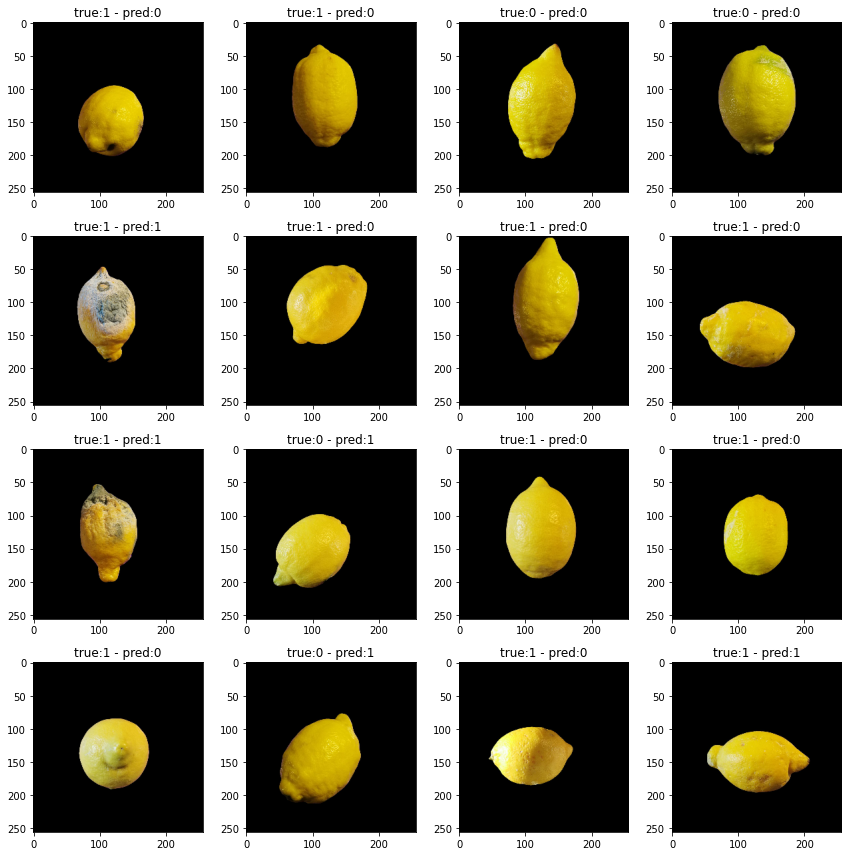

In [31]:
# find area that needs work in model

def predict_threshold(pred, threshold):
    if pred > threshold:
        return 1
    else:
        return 0

# plot some predictions
fig, axes = plt.subplots(4, 4, figsize = (12, 12))

for x_batch, y_batch in validation_data.take(1).as_numpy_iterator():
    y_preds = model.predict(x_batch)
    for img, label, y_pred, ax in zip(x_batch, y_batch, y_preds, axes.flat):
        ax.imshow(np.squeeze(img)/255)
        ax.set_title(f'true:{int(label)} - pred:{predict_threshold(y_pred, 0.5)}')
plt.tight_layout();

In [ ]:
# Save model version 03 with datetime stamp

datetime_stamp = datetime.now().strftime("%Y-%m-%d %I:%M %p")

models.save_model(model, f"../models/basic_model_03_{datetime_stamp}") # need to add date and time to this label & send to model folder too

NameError: name 'model' is not defined

In [ ]:
ti1 = expand_dims(test_img1, axis=0)

In [ ]:
ti1.shape

TensorShape([1, 1056, 1056, 3])

In [ ]:
model.predict(train_data)

array([[0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],
       [0.5215643],


In [ ]:
# Add class weights to model.fit function

### Resize Any Image to 256 x 256 with 'resize_with_pad'

In [ ]:
# tensorflow resize function  
from tensorflow.image import resize_with_pad as rwp

test_img1_rwp = rwp(test_img1, target_height = 256, target_width = 256)

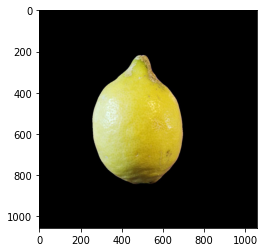

In [ ]:
plt.imshow(test_img1);

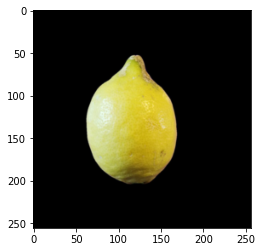

In [ ]:
 plt.imshow(test_img1_rwp/255);

In [ ]:
# recreate date with correct random seed (2)

In [ ]:
# lemon_model = model.save

### Account for Class Imbalance Between Healthy and Unhealthy Images

In [ ]:
# class 0 = healthy
# class 1 = unhealthy

In [ ]:
# Class Imbalance
neg = 740 # number of healthy images
pos = 1950 #number of unhealthy images
total = neg + pos
print('Examples:\n    Total Number Of Images: {}\n    Unhealthy Lemon Images: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total Number Of Images: 2690
    Healthy Lemon Images: 1950 (72.49% of total)



In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.82
Weight for class 1: 0.69


In [ ]:
# Train a model with class weights
# Need to check that this code will work with code above

# weighted_model = make_model()
# weighted_model.load_weights(initial_weights)

# weighted_history = weighted_model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     callbacks=[early_stopping],
#     validation_data=(val_features, val_labels),
#     # The class weights go here
#     class_weight=class_weight)


model = initialize_model()

es = EarlyStopping(patience=2)

weighted_histroy = model.fit(train_data, 
          batch_size=16, 
          epochs=5,
          validation_data = validation_data,
          callbacks=[es], 
          class_weight = class_weight
          )

Epoch 1/5
48/48 [==============================] - 331s 7s/step - loss: 1.2156 - accuracy: 0.3179 - val_loss: 0.6947 - val_accuracy: 0.2580
Epoch 2/5
48/48 [==============================] - 366s 8s/step - loss: 0.7021 - accuracy: 0.2867 - val_loss: 0.6955 - val_accuracy: 0.2580
Epoch 3/5
48/48 [==============================] - 341s 7s/step - loss: 0.7021 - accuracy: 0.2867 - val_loss: 0.6963 - val_accuracy: 0.2580


In [ ]:
print(model.evaluate(train_data, verbose=0))

[0.6958991289138794, 0.2866622507572174]


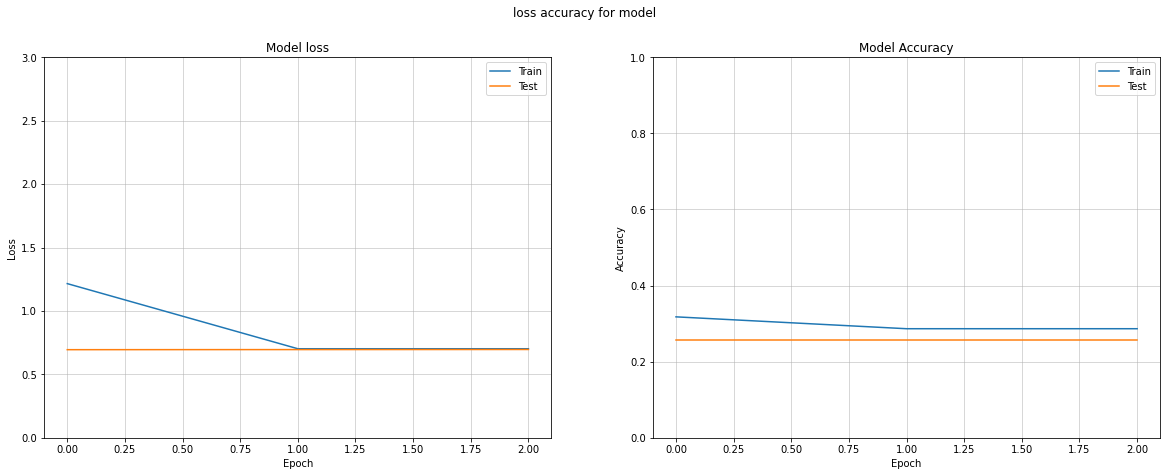

In [ ]:
plot_loss_accuracy(weighted_histroy, title="loss accuracy for model")

In [ ]:
### SWITCH THE WEIGHTS

model = initialize_model()

es = EarlyStopping(patience=2)

weighted_histroy = model.fit(train_data, 
          batch_size=16, 
          epochs=5,
          validation_data = validation_data,
          callbacks=[es], 
          class_weight = {0: weight_for_1, 1: weight_for_0}
          )


Epoch 1/5
48/48 [==============================] - 370s 8s/step - loss: 0.9088 - accuracy: 0.6762 - val_loss: 0.6750 - val_accuracy: 0.7420
Epoch 2/5
48/48 [==============================] - 326s 7s/step - loss: 0.5784 - accuracy: 0.7133 - val_loss: 0.5592 - val_accuracy: 0.7420
Epoch 3/5
48/48 [==============================] - 349s 7s/step - loss: 0.5697 - accuracy: 0.7133 - val_loss: 0.6105 - val_accuracy: 0.7420
Epoch 4/5
48/48 [==============================] - 366s 8s/step - loss: 0.5312 - accuracy: 0.7133 - val_loss: 0.7297 - val_accuracy: 0.7420


In [ ]:
builder = ImageFolder(path_to_data)

NameError: name 'ImageFolder' is not defined

In [ ]:
# Need to check this code to see if it works with other code - i.e. not missing info

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [ ]:
plot_metrics(weighted_history)

In [ ]:
# Load a saved model

lou = models.load_model(f"../models/basic_model_02}")

OSError: No file or directory found at ../models/basic_model_03_2022-08-13 02:13 PM

In [ ]:
# resave model in hdf5 format for Ling 
models.save_model(lou, '../models/basic_model_02_ling.hdf5', save_format = 'h5')

In [45]:
# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66

libcudnn8:
  Installed: 8.0.5.39-1+cuda11.1
  Candidate: 8.5.0.96-1+cuda11.7
  Version table:
     8.5.0.96-1+cuda11.7 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.5.0.96-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda11.5 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda10.2

Found existing installation: tensorflow 2.9.1
Uninstalling tensorflow-2.9.1:
  Successfully uninstalled tensorflow-2.9.1
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
